# Code Debugging System

- Author: [HeeWung Song(Dan)](https://github.com/kofsitho87)
- Design: 
- Peer Review: [Jongcheol Kim](https://github.com/greencode-99), [Heeah Kim](https://github.com/yellowGangneng)
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/18-CodeDebuggingSystem.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/18-CodeDebuggingSystem.ipynb)

## Overview

In this tutorial, we'll build an AI-powered Python code debugging system using LangGraph. This system automates the debugging process by executing code, analyzing errors, suggesting fixes, and validating corrections.

- **Code Execution**: Run Python code and capture any errors
- **Error Analysis**: Use AI to analyze the error and identify the cause
- **Code Correction**: Generate fixed code and unit tests
- **Validation**: Verify the corrected code works properly

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Basic Components](#basic-components)
- [Building LangGraph Workflow](#building-langgraph-workflow)


### References
- [Debugging complex codebases](https://onsiter.medium.com/debugging-complex-codebases-a-comprehensive-guide-5f8528c48ce4)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.

**[Note]**
- The `langchain-opentutorial` is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
- Check out the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [ ]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [ ]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_community",
        "langchain_openai",
        "langgraph",
    ],
    verbose=False,
    upgrade=False,
)

In [ ]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "CodeDebuggingSystem",
    }
)

You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

**[Note]** This is not necessary if you've already set the required API keys in previous steps.

In [1]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Basic Components

Our debugging system is built upon three fundamental utility components that handle code execution, command management, and AI response parsing.

- **Code Executor**: This component provides safe **Python code execution** in an isolated environment, capturing outputs and errors. It serves as the foundation for both initial code testing and validation of corrections.

- **Command Executor**: This component manages system-level operations, particularly package installations. It automatically detects the environment (UV/pip) and ensures proper command execution across different Python environments.

- **Code Block Parser**: The `CodeBlockParser` is a custom LangChain output parser that processes AI model responses. By extending `BaseOutputParser`, it extracts and categorizes markdown code blocks into structured data, making it seamlessly integrable with LangChain's LCEL pipelines. This parser is crucial for handling AI-generated code corrections and test cases.

- **LLM Components**: Handles intelligent code analysis and correction through:
  - Chain configuration using ChatOpenAI and custom prompts
  - Structured prompt template for error analysis, code correction, and test generation

These components work together to provide the essential functionality needed by our LangGraph-based debugging workflow.

### Code Executor

First, **Code Executor** is the process of running Python code and capturing any errors that occur during execution.

The `execute_code` function safely executes Python code in a temporary environment and captures comprehensive execution results including output and error messages. It returns a structured result object that serves as the foundation for our debugging workflow's analysis and correction steps.

In [5]:
import os
import sys
import subprocess
import io
import contextlib

from typing_extensions import TypedDict
from typing import Optional

class ExecutionResult(TypedDict):
    success: bool
    output: Optional[str]
    error: Optional[str]
    code: Optional[str]

def execute_code(source: str) -> ExecutionResult:
    """
    Unified code execution function.
    
    If 'source' is a valid file path, the file is read and executed using subprocess.
    Otherwise, 'source' is treated as a Python code snippet and executed in-process.
    
    Args:
        source (str): Either a path to a Python file or a Python code snippet.
    
    Returns:
        ExecutionResult: A result dictionary with:
            - success (bool)
            - output (str): captured stdout
            - error (Optional[str]): error message if any
            - code (str): source code that was executed
    """
    # If the source is a file path, execute the file at that path.
    if os.path.isfile(source):
        file_path = source
        with open(file_path, 'r', encoding='utf-8') as f:
            code = f.read()
        # Compile the file content to check for syntax errors in advance.
        try:
            compile(code, file_path, 'exec')
        except SyntaxError as se:
            return ExecutionResult(
                success=False,
                output="",
                error=f"SyntaxError: {se}",
                code=code
            )
        # Execute the file via subprocess (capture runtime errors)
        result = subprocess.run(
            [sys.executable, file_path],
            capture_output=True,
            text=True
        )
        success = result.returncode == 0
        error_msg = result.stderr if not success else None
        return ExecutionResult(
            success=success,
            output=result.stdout,
            error=error_msg,
            code=code
        )
    else:
        # Otherwise, assume the source is a code string and execute it internally.
        code = source
        try:
            compiled_code = compile(code, "<string>", "exec")
        except SyntaxError as se:
            return ExecutionResult(
                success=False,
                output="",
                error=f"SyntaxError: {se}",
                code=code
            )
        # Capture output during exec() execution
        output_capture = io.StringIO()
        try:
            with contextlib.redirect_stdout(output_capture):
                exec(compiled_code, {})
        except Exception as e:
            return ExecutionResult(
                success=False,
                output=output_capture.getvalue(),
                error=str(e),
                code=code
            )
        return ExecutionResult(
            success=True,
            output=output_capture.getvalue(),
            error=None,
            code=code
        )

Let's test our debugging system with a Python code sample that contains multiple issues including syntax errors, type errors, and PEP 8 violations. 

This student grade processing code demonstrates common programming mistakes such as missing colons, mixed data types, and naming convention violations that our system will detect and fix.

In [2]:
sample_code = """
# Code to visualize student grades
import matplotlib.pyplot as plt

# Code to process student grades
class student:  # Violation of class naming convention
    def __init__(self,name,scores):  # Violation of parameter spacing convention
        self.name=name  # No whitespace around operator
        self.scores=scores
    
    def calculate_average(self):  
        total = 0
        for score in self.scores
            total += score  # Syntax error: missing colon
        return total/len(self.scores)  # Potential ZeroDivisionError risk

    def visualize_scores(self):
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(self.scores)), self.scores)
        plt.title(f"{self.name}'s Scores")
        plt.xlabel('Subject')
        plt.ylabel('Score')
        plt.show()
    
    def print_info(self):
        avg = self.calculate_average()
        print(f"Student: {self.name}")
        print(f"Scores: {self.scores}")
        print(f"Average: {avg}")
        self.visualize_scores()


def main():
    # Mixed integers and strings in list - potential type error
    scores = [85, 90, "95", 88, 92]
    student1 = student("John Doe", scores)
    student1.print_info()

if __name__ == "__main__"
    main()
"""

# test code
result = execute_code(sample_code)

print(f"Success: {result['success']}")
print(f"Error: {result['error']}")
print(f"Output: {result['output']}")

Success: False
Error: SyntaxError: expected ':' (<string>, line 13)
Output: 


### Command Executor

The `CommandExecutor` provides a unified interface for executing system commands and installing packages across different Python environments. It automatically detects whether to use UV or pip package manager and adapts its behavior accordingly using the Strategy pattern. The system consists of a base executor class with specialized implementations for UV and pip environments, ensuring consistent command execution regardless of the environment setup.

In [10]:
from typing import List, Union
from abc import ABC, abstractmethod

class BaseCommandExecutor(ABC):
    """Base class for command execution"""
    
    def __init__(self):
        self.python_path = sys.executable
        self.venv_path = os.path.dirname(os.path.dirname(self.python_path))
    
    @abstractmethod
    def install_package(self, package: str) -> bool:
        """Package installation method"""
        pass
    
    def run_command(self, command: Union[List[str], str], shell: bool = False) -> bool:
        """Execute general command"""
        try:
            if isinstance(command, str):
                shell = True
            
            result = subprocess.run(
                command,
                shell=shell,
                text=True,
                capture_output=True,
                check=True
            )
            
            if result.stdout:
                print("Output:", result.stdout)
            if result.stderr:
                print("Stderr:", result.stderr)
            
            return True
            
        except subprocess.CalledProcessError as e:
            print(f"Command failed: {e}")
            print("Error output:", e.stderr)
            return False
        except Exception as e:
            print(f"Unexpected error: {e}")
            return False

class UVCommandExecutor(BaseCommandExecutor):
    """Executor for UV environment"""
    
    def install_package(self, package: str) -> bool:
        cmd = ["uv", "pip", "install", package]
        print(f"Installing with UV: {' '.join(cmd)}")
        return self.run_command(cmd)

class VenvCommandExecutor(BaseCommandExecutor):
    """Executor for standard venv environment"""
    
    def install_package(self, package: str) -> bool:
        cmd = [self.python_path, "-m", "pip", "install", package]
        print(f"Installing with pip: {' '.join(cmd)}")
        return self.run_command(cmd)
    
class PoetryCommandExecutor(BaseCommandExecutor):
    """Executor for Poetry environment"""
    
    def install_package(self, package: str) -> bool:
        cmd = ["poetry", "add", package]
        print(f"Installing with Poetry: {' '.join(cmd)}")
        return self.run_command(cmd)
    
class CondaCommandExecutor(BaseCommandExecutor):
    """Executor for Conda environment"""
    
    def install_package(self, package: str) -> bool:
        cmd = ["conda", "install", "-y", package]
        print(f"Installing with Conda: {' '.join(cmd)}")
        return self.run_command(cmd)
    

def get_appropriate_executor() -> BaseCommandExecutor:
    """
    Returns appropriate executor for current environment
    """
    def check_notebook_env() -> bool:
        """
        Checks if the current environment is a Jupyter Notebook.
        """
        try:
            from IPython import get_ipython
            ip = get_ipython()
            # If 'IPKernelApp' exists, it means it is running in a Jupyter Notebook or qtconsole.
            if ip is not None and 'IPKernelApp' in ip.config:
                print("Jupyter Notebook environment detected.")
                return True
        except Exception:
            return False
    
    def check_uv_available() -> bool:
        try:
            result = subprocess.run(
                ["uv", "--version"],
                capture_output=True,
                text=True
            )
            return result.returncode == 0
        except Exception:
            return False
        
    def check_poetry_available() -> bool:
        if os.path.exists("pyproject.toml"):
            try:
                import toml
            except ImportError:
                toml = None

            if toml:
                try:
                    config = toml.load("pyproject.toml")
                    if "tool" in config and "poetry" in config["tool"]:
                        print("Poetry configuration detected in pyproject.toml.")
                        return True
                except Exception:
                    pass
            else:
                # If the toml module is not installed, assume the environment based on the file's existence
                print("pyproject.toml found (toml module not installed), assuming Poetry environment.")
                return True
        return False
    
    def check_conda_available() -> bool:
        try:
            result = subprocess.run(["conda", "--version"], capture_output=True, text=True)
            return result.returncode == 0
        except Exception: 
            return False
    
    # Check environment type
    if check_poetry_available():
        print("Poetry environment detected, using PoetryCommandExecutor")
        return PoetryCommandExecutor()
    elif check_uv_available():
        print("UV environment detected, using UVCommandExecutor")
        return UVCommandExecutor()
    elif check_conda_available():
        print("Conda environment detected, using CondaCommandExecutor")
        return CondaCommandExecutor()
    else:
        print("Standard venv environment detected, using VenvCommandExecutor")
        return VenvCommandExecutor()

class CommandExecutor:
    """
    Unified interface for command execution
    """
    def __init__(self):
        self.executor = get_appropriate_executor()
    
    def execute_bash_commands(self, commands: List[str]) -> bool:
        """
        Execute list of bash commands
        """
        for cmd in commands:
            print(f"\nExecuting: {cmd}")
            
            # Handle pip install commands
            if cmd.startswith("pip install"):
                package = cmd.replace("pip install", "").strip()
                success = self.executor.install_package(package)
            else:
                success = self.executor.run_command(cmd, shell=True)
            
            if not success:
                print(f"Failed to execute: {cmd}")
                return False
        return True

Let's test our CommandExecutor by installing required packages (`matplotlib` and `pytest`) using the appropriate package manager for our environment.

In [11]:
# Test CommandExecutor

executor = CommandExecutor()
executor.execute_bash_commands(["pip install matplotlib", "pip install pytest"])

UV environment detected, using UVCommandExecutor

Executing: pip install matplotlib
Installing with UV: uv pip install matplotlib
Stderr: Using Python 3.11.6 environment at: /Users/heewungsong/SideProjects/LangChain-OpenTutorial/.venv
Resolved 11 packages in 118ms
Installed 1 package in 33ms
 + matplotlib==3.10.0


Executing: pip install pytest
Installing with UV: uv pip install pytest
Stderr: Using Python 3.11.6 environment at: /Users/heewungsong/SideProjects/LangChain-OpenTutorial/.venv
Resolved 4 packages in 44ms
Installed 1 package in 9ms
 + pytest==8.3.4



True

### Code Block Parser

The `CodeBlockParser` is a custom LangChain output parser that processes AI model responses, extracting and categorizing markdown code blocks into structured data. By extending `BaseOutputParser`, it extracts code blocks with specific tags (**corrected** for fixed code, **tests** for test code) from the AI's response text. This parser enables seamless integration with LangChain's LCEL pipelines while providing a structured way to handle different types of code blocks in our debugging workflow.

In [5]:
import re
from typing import List
from langchain_core.output_parsers import BaseOutputParser
from pydantic import BaseModel, Field

    
class CodeBlocks(BaseModel):
    """Dictionary structure to hold code blocks by language"""
    corrected: List[str] = Field(default_factory=list, description="Corrected code")
    bash: List[str] = Field(default_factory=list, description="Bash commands")

class CodeBlockParser(BaseOutputParser[CodeBlocks]):
    """
    Parser for markdown code blocks
    Classifies and returns code blocks by language in Dictionary format
    """
    
    def parse(self, text: str) -> CodeBlocks:
        """Extract and classify code blocks from text by language"""
        
        # Initialize code blocks dictionary
        code_blocks = {
            'corrected': [],
            'bash': [],
        }
        
        # Pattern to match ```language:type format
        pattern = r"```(\w+):?(\w+)?\n(.*?)\n```"
        matches = re.finditer(pattern, text, re.DOTALL)
        
        for match in matches:
            language = match.group(1).lower()
            block_type = match.group(2) or language  # use language as type if type not specified
            code = match.group(3).strip()
            
            if block_type in code_blocks:
                code_blocks[block_type].append(code)
        
        return CodeBlocks(**code_blocks)

    @property
    def _type(self) -> str:
        """Specify parser type"""
        return "code_block_parser"
    
    def get_format_instructions(self) -> str:
        """Format instructions for parsing"""
        return """Code should be returned in markdown format as follows:
        ```language
        your_code_here
        ```
        where language should be 'python:corrected' or 'bash'."""

In [9]:
# Test CodeBlockParser

sample_output_from_llm = """### Error Analysis

1. **Identifying Error Line(s) and Root Cause**:
   - The error occurs at the line `total += score` in the `calculate_average` method. The `scores` list contains a string `"95"` instead of an integer, which leads to a `TypeError` when the code attempts to add this string to an integer (`total`).
   - The root cause is that the `scores` list is not type-checked, allowing incompatible types (strings instead of integers) to be included.

2. **Best Practices to Avoid This Error**:
   - Always validate input data types before performing operations on them.
   - Use type hints in function definitions to clarify expected input types.
   - Consider using exception handling to gracefully manage unexpected data types.

### Code Correction

```python:corrected
class Student:
    def __init__(self, name, scores):
        self.name = name
        # Ensure all scores are converted to integers
        self.scores = [self.validate_score(score) for score in scores]

    def validate_score(self, score):
        try:
            return int(score)  # Convert to int, raises ValueError if conversion fails
        except ValueError:
            raise ValueError(f"Invalid score: {score}. Score must be an integer or convertible to an integer.")

    def calculate_average(self):  
        total = 0
        for score in self.scores:
            total += score
        return total / len(self.scores)

    def print_info(self):
        avg = self.calculate_average()
        print(f"Student: {self.name}")
        print(f"Scores: {self.scores}")
        print(f"Average: {avg}")


def main():
    scores = [85, 90, "95", 88, 92]  # Example input with a string convertible to int
    student1 = Student("John Doe", scores)
    student1.print_info()


if __name__ == "__main__":
    main()
```

```bash
pip install matplotlib
```

### Recommendations

1. **Code Quality (PEP 8)**:
   - Ensure class names are capitalized (e.g., `Student` instead of `student`).
   - Use consistent naming conventions and spacing in the code.

2. **Runtime Considerations**:
   - Consider edge cases like empty score lists before performing operations that assume non-empty inputs.

3. **Package Dependencies**:
   - For this simple program, no external packages are required. However, if you expand the functionality (e.g., using a database or web framework), make sure to manage dependencies with a tool like `pip` and maintain a `requirements.txt` file.

By following these recommendations, the code will be more robust, maintainable, and user-friendly.
"""

code_block_parser = CodeBlockParser()
code_block_parser_result = code_block_parser.invoke(sample_output_from_llm)

corrected = "\n".join(code_block_parser_result.corrected)

print("------- Fixed Code -------")
print(corrected)

print("\n------- Bash Commands -------")
print(code_block_parser_result.bash)

------- Fixed Code -------
class Student:
    def __init__(self, name, scores):
        self.name = name
        # Ensure all scores are converted to integers
        self.scores = [self.validate_score(score) for score in scores]

    def validate_score(self, score):
        try:
            return int(score)  # Convert to int, raises ValueError if conversion fails
        except ValueError:
            raise ValueError(f"Invalid score: {score}. Score must be an integer or convertible to an integer.")

    def calculate_average(self):  
        total = 0
        for score in self.scores:
            total += score
        return total / len(self.scores)

    def print_info(self):
        avg = self.calculate_average()
        print(f"Student: {self.name}")
        print(f"Scores: {self.scores}")
        print(f"Average: {avg}")


def main():
    scores = [85, 90, "95", 88, 92]  # Example input with a string convertible to int
    student1 = Student("John Doe", scores)
    student1.prin

### LLM Components

The LLM pipeline integrates ChatGPT with a specialized prompt template designed for code debugging tasks. The prompt guides the model to perform error analysis, code correction, and test generation in a structured format. The output is then processed through a custom parser, enabling seamless integration with the rest of our debugging workflow.

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

model = ChatOpenAI(model="gpt-4o-mini")
prompt = PromptTemplate.from_template("""You are given a Python code snippet along with an error message that occurs when running the code. Analyze the code, identify the cause of the error, and provide a corrected version of the code.
                                      
---

**Context**:
- Error Message: {ERROR_MESSAGE}
- Original Code: 
{CODE_SNIPPET}
                                      
**Format Requirements**:
- Use **EXACTLY** these code block tags:
  - Corrected code: ```python:corrected
  - Package installation: ```bash
- Never use generic ```python code blocks

**Response Structure**:

### 1. Error Analysis
- Identify specific line numbers causing the error
- Explain root cause using Python runtime mechanics
- Provide prevention strategies for similar errors

### 2. Code Correction
```python:corrected
# MUST include:
# - Error fixes with line comments
# - Enhanced exception handling
# - PEP 8 compliance
# - Type hints for critical functions

### 3. Recommendations            
- Package Dependencies(DONT FORGET)
```bash
pip install [detected_packages]                              
```
    - Scan import statements for 3rd-party packages
    - Exclude standard library modules (e.g., os, sys)
    - List packages alphabetically in one-line install command
                                      
- Code quality (PEP 8)
- Runtime considerations
                                      
Format your response with clear sections and tagged code blocks as shown above.
""")

chain = prompt | model | CodeBlockParser()

Now, let's try to use the `CodeBlockParser` to parse the output of the LLM.

In [11]:
debug_result = execute_code(sample_code)

response = chain.invoke({
    "ERROR_MESSAGE": debug_result['error'], 
    "CODE_SNIPPET": debug_result['code']
})

print("------- Fixed Code -------")
for code in response.corrected:
    print(code)

print("\n------- Bash Commands -------")
for command in response.bash:
    print(command)

------- Fixed Code -------
# Code to visualize student grades
import matplotlib.pyplot as plt

# Code to process student grades
class Student:  # Fixed class naming convention
    def __init__(self, name: str, scores: list[int]):  # Fixed parameter spacing and added type hints
        self.name = name  # Added whitespace around operator
        self.scores = scores
    
    def calculate_average(self) -> float:  # Added return type hint
        total = 0
        for score in self.scores:  # Fixed syntax error: added colon
            total += score
        return total / len(self.scores) if self.scores else 0.0  # Added check to prevent ZeroDivisionError

    def visualize_scores(self) -> None:  # Added return type hint
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(self.scores)), self.scores)
        plt.title(f"{self.name}'s Scores")
        plt.xlabel('Subject')
        plt.ylabel('Score')
        plt.show()
    
    def print_info(self) -> None:  # Added return type 

## Building LangGraph Workflow

In this section, we'll build an automated debugging workflow using LangGraph. This workflow will systematically process code, identify errors, suggest fixes, and validate the corrections. Let's break down the key components:

- **Execute Code**: First, run the code and capture any errors
- **Analyze Errors**: If errors occur, use AI to analyze them and suggest fixes
- **Install Dependencies**: Install any required packages
- **Decide Next Step**: Either end the process if successful, or retry debugging

The workflow continues until either:
- The code runs successfully without errors
- The maximum number of debug attempts (3) is reached

Let's implement each component and see how they work together in our debugging system.

### Define the State

The **AgentState** serves as the central data structure tracking progress through the debugging workflow. This stateful approach enables iterative improvements by preserving critical debugging context between cycles.

**Key State Components**:
1. **Original Code**: Preserves the initial code before any modifications
2. **Code**: Current version of the code being debugged
3. **Error**: Captured runtime error message (if any)
4. **Dependencies**: List of required packages identified by AI analysis
5. **Execution Result**: Detailed outcome of code execution attempts (success status, raw output/error)
6. **Debug Attempts**: Counter tracking retries (max 3 attempts)
7. **Fix History**: List of debugging attempts with corresponding errors and fixes

The state evolves through each workflow iteration, preserving the debugging history while allowing progressive code improvements.

In [18]:
from typing import Optional, List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END

# Define the state of the agent
class AgentState(TypedDict):
    original_code: str  # Original code
    code: str
    error: Optional[str]
    dependencies: List[str]
    execution_result: Optional[ExecutionResult]
    debug_attempts: int
    fix_history: List[dict]

# Build the graph
builder = StateGraph(AgentState)

### Define the Nodes

The workflow consists of five specialized nodes that form the debugging pipeline:

1. **Execute Code Node** (`execute_code_node`):
   - Runs the current code version
   - Captures execution results (success status, output/error)
   - Updates state with error message if failure occurs

2. **Analyze Error Node** (`analyze_error_node`):
   - Activates only when errors exist
   - Uses LLM to diagnose errors and generate:
     - Corrected code versions
     - Required dependencies
     - Validation test cases

3. **Install Dependencies Node** (`install_deps_node`):
   - Processes AI-identified package requirements
   - Executes system commands using environment-aware executor
   - Supports both pip and UV package managers

4. **Decision Node** (`decide_next_step`):
   - Evaluates workflow progress:
     - Ends on successful execution
     - Limits to 3 debug cycles
     - Triggers retries otherwise
   - Acts as workflow control gate

Nodes maintain single responsibility while sharing state through the AgentState structure, enabling modular debugging steps.

In [19]:
# Initialize the components
executor = CommandExecutor()
code_parser = CodeBlockParser()
llm_chain = prompt | model

# Define the nodes
def execute_code_node(state: AgentState) -> AgentState:
    if os.path.isfile(state["code"]):
        with open(state["code"], "r", encoding="utf-8") as f:
            file_content = f.read()
        state["original_code"] = file_content

    result = execute_code(state["code"])

    updated_attempts = state["debug_attempts"] + 1
    print(f"Debug attempts updated to: {updated_attempts}")
    return {
        **state,
        # "original_code": result["code"],
        "execution_result": result,
        "error": result["error"] if not result["success"] else None,
        "debug_attempts": updated_attempts
    }

def analyze_error_node(state: AgentState) -> AgentState:
    if not state["error"]:
        return state
    
    response = llm_chain.invoke({
        "ERROR_MESSAGE": state["error"],
        "CODE_SNIPPET": state["code"]
    })
    parsed = code_parser.parse(response.content)

    # Record the debugging attempt details:
    # - attempt: Current attempt number
    # - error: Current error message
    # - fixed_code: Corrected code from AI (if available)
    fix_record = {
        "attempt": state["debug_attempts"],
        "error": state["error"],
        "fixed_code": "\n".join(parsed.corrected) if parsed.corrected else None
    }
    
    return {
        **state,
        "code": "\n".join(parsed.corrected) if parsed.corrected else state["code"],  # Update code with corrected version
        "dependencies": parsed.bash,
        "fix_history": state.get("fix_history", []) + [fix_record]
    }

def install_deps_node(state: AgentState) -> AgentState:
    """Install required dependencies"""
    if state["dependencies"]:
        for package in state["dependencies"]:
            # Ensure the command starts with 'pip install'
            if not package.startswith("pip install"):
                package = f"pip install {package}"
            executor.execute_bash_commands([package])
    return state

def decide_next_step(state: AgentState) -> str:
    """Decision node that determines the next step in the workflow
    
    Returns:
        str: One of three possible outcomes:
            - "end": If code execution was successful
            - "max_attempts_reached": If maximum debug attempts (3) reached
            - "retry": If further debugging is needed
    """
    print(f"Current debug attempts: {state['debug_attempts']}")

    # First check for maximum attempts to ensure we stop
    if state["debug_attempts"] >= 3:
        print("Max attempts reached, ending workflow")
        return "max_attempts_reached"
    # Then check for successful execution
    if state["execution_result"]["success"] and not state.get("error"):
        print("Successful execution, ending workflow")
        return "end"
    # Continue only if within attempt limit and not successful
    print("Continuing debug cycle")
    return "retry"

# Add the nodes
builder.add_node("execute", execute_code_node)
builder.add_node("analyze", analyze_error_node)
builder.add_node("install", install_deps_node)

Jupyter Notebook environment detected.
Notebook environment detected, using VenvCommandExecutor with the current notebook's Python environment.


### Define the Edges

The edge configuration defines the workflow's logical flow and decision points:

1. **Entry Point**:
   - Workflow starts with code execution (execute node)
   - `builder.set_entry_point("execute")`

2. **Sequential Flow**:
   - **Execute** → **Analyze**: Code execution results flow to error analysis
   - **Analyze** → **Install**: Identified dependencies proceed to installation
   - **Install** → **Execute**: After setup, proceed to validation testing

3. **Conditional Branching**:
   - Post-test evaluation determines next step:
     - **Success**: Terminate workflow (END)
     - **Failure**: Restart cycle if under 3 attempts (retry → execute)
     - **Max Attempts**: Terminate after 3 retries (max_attempts_reached → END)
   - Implemented via `add_conditional_edges()`

This edge configuration creates a robust debugging loop that automatically handles retries while ensuring the process eventually terminates, either through successful debugging or reaching the attempt limit.

In [20]:
# Add edges to create a more logical flow
builder.set_entry_point("execute")
builder.add_edge("analyze", "install")
builder.add_edge("install", "execute")  # After installing dependencies, execute the code again

# Add conditional edges from execute node
builder.add_conditional_edges(
    "execute",
    decide_next_step,
    {
        "end": END,  # If execution successful, end workflow
        "max_attempts_reached": END,  # If max attempts reached, end workflow
        "retry": "analyze"  # If errors persist, continue debugging
    }
)

In [21]:
# Compile the graph
app = builder.compile()

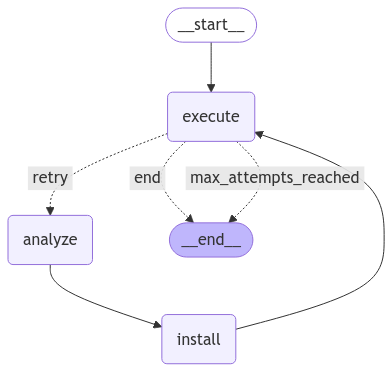

In [16]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run the Workflow

Let's compile our builder graph and run it with the sample code we created earlier to see our debugging system in action.

In [11]:
# Run the graph
initial_state = {
    "original_code": sample_code,
    "code": sample_code,
    "error": None,
    "dependencies": [],
    "debug_attempts": 0,
    "fix_history": []
}

result = app.invoke(initial_state)

# Print the results
print(f"Installed Dependencies: {result['dependencies']}")
print(f"Debug Attempts: {result['debug_attempts']}")

print("\n\n----- Original Code -----")
print(f"{result['original_code']}")

print("\n\n----- Final Code -----")
print(f"{result['code']}")

print("\n\n----- Fix History -----")
print(f"Fix History Length: {len(result['fix_history'])}")
for fix in result['fix_history']:
    print(f"Attempt: {fix['attempt']}")
    print("----- Error -----")
    print(f"{fix['error']}")
    print("----- Fixed Code -----")
    print(f"{fix['fixed_code']}")


Debug attempts updated to: 1
Current debug attempts: 1
Continuing debug cycle

Executing: pip install matplotlib
Installing with pip: /Users/heewungsong/SideProjects/LangChain-OpenTutorial/.venv/bin/python -m pip install matplotlib
Command failed: Command '['/Users/heewungsong/SideProjects/LangChain-OpenTutorial/.venv/bin/python', '-m', 'pip', 'install', 'matplotlib']' returned non-zero exit status 1.
Error output: /Users/heewungsong/SideProjects/LangChain-OpenTutorial/.venv/bin/python: No module named pip

Failed to execute: pip install matplotlib
Debug attempts updated to: 2
Current debug attempts: 2
Successful execution, ending workflow
Installed Dependencies: ['pip install matplotlib']
Debug Attempts: 2


----- Original Code -----
# Code to visualize student grades
import matplotlib.pyplot as plt

# Code to process student grades
class Student:  # Fixed class naming convention to PascalCase
    def __init__(self, name: str, scores: list[int]):  # Added type hints and corrected para

In [ ]:
sample_code_file = "./data/18-CodeDebuggingSystem-SampleCode-01.py"

# Run the graph
initial_state = {
    "original_code": sample_code_file,
    "code": sample_code_file,
    "error": None,
    "dependencies": [],
    "debug_attempts": 0,
    "fix_history": []
}

result = app.invoke(initial_state)

# Print the results
print(f"Installed Dependencies: {result['dependencies']}")
print(f"Debug Attempts: {result['debug_attempts']}")

print("\n\n----- Original Code -----")
print(f"{result['original_code']}")

print("\n\n----- Final Code -----")
print(f"{result['code']}")

print("\n\n----- Fix History -----")
print(f"Fix History Length: {len(result['fix_history'])}")
for fix in result['fix_history']:
    print(f"Attempt: {fix['attempt']}")
    print("----- Error -----")
    print(f"{fix['error']}")
    print("----- Fixed Code -----")
    print(f"{fix['fixed_code']}")


Debug attempts updated to: 1
Current debug attempts: 1
Continuing debug cycle
Debug attempts updated to: 2
Current debug attempts: 2
Successful execution, ending workflow
Installed Dependencies: []
Debug Attempts: 2


----- Original Code -----
def faulty_addition():
    return "Hello, " + 10

if __name__ == "__main__":
    print("Starting runtime error test...")
    result = faulty_addition()
    print("Result:", result)


----- Final Code -----
def faulty_addition() -> str:  # Added type hint for the return type
    try:
        # Correcting the error by converting the integer to a string
        return "Hello, " + str(10)  # Convert 10 to a string
    except Exception as e:
        return f"An error occurred: {e}"  # Enhanced exception handling

# Example call to the function
if __name__ == "__main__":
    result = faulty_addition()
    print(result)  # Display the result


----- Fix History -----
Fix History Length: 1
Attempt: 1
----- Error -----
Traceback (most recent call last):
 